# CNN model (from "Fast Solar Image Classification Using Deep Learning and its Importance for Automation in Solar Physics" - Convolutional neural network)

## 0. Load modules


In [1]:
# Main libraries used all the time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Operating system libraries
import os
import sys

# Machine learning libraries
import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

import torch.nn as nn
import torch.optim as optim
import argparse
from tqdm import tqdm


from torchvision.transforms import v2 # library to define the transforms

!pip install torcheval  # needs to run on google colab, on local machine you can just "pip install torcheval" in the terminal
from torcheval.metrics.functional import multiclass_f1_score

# Visualization and debugging
from sklearn.metrics import confusion_matrix
import seaborn as sns
!pip install sunpy
from sunpy.visualization.colormaps import color_tables as ct


## 1. Import the data, create the dataset, define the Dataloaders

### 1.1 Declare data path

In [2]:
# For Google Colab, mount Google Drive, for local environments, get local path (github)

# Change with the appropriate path. Log in into Drive and create the folders with the data

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Carlos
    #folder0_path = '/content/drive/My Drive/solar_jets/data0'
    #folder0_test_path = '/content/drive/My Drive/solar_jets/data0_test'
    #folder1_path = '/content/drive/My Drive/solar_jets/data1'
    #folder1_test_path = '/content/drive/My Drive/solar_jets/data1_test'

    # Julie
    #folder0_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0'
    #folder1_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1'
    #folder0_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data0_test'
    #folder1_test_path = '/content/drive/My Drive/Colab Notebooks/CS433-project2/data1_test'

    #Adrien
    folder0_path = '/content/drive/My Drive/Machine Learning/Projet/data0'
    folder1_path = '/content/drive/My Drive/Machine Learning/Projet/data1'
    folder0_test_path = '/content/drive/My Drive/Machine Learning/Projet/data0_test'
    folder1_test_path = '/content/drive/My Drive/Machine Learning/Projet/data1_test'

else:
    # For local environments like VS Code
    folder0_path = './data0'
    folder1_path = './data1'
    folder0_test_path = './data0_test'
    folder1_test_path = './data1_test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Declare the class and the transforms

In [3]:
class NPZDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir

        # in self.files, only add f if it has 30 samples
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = transform

    # Check if the file has 30 samples, if not, don't include it in self.files (see above)
    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']

        # Rearrange dimensions to (30, 166, 166) for PyTorch (insted of (166, 166, 30))
        data = np.moveaxis(data, -1, 0)

        # assign label 1 if data is from data1, 0 if from data0
        label = 1.0 if 'data1' in self.data_dir else 0.0
        return torch.from_numpy(data).float(), label

In [4]:
mean = 51.6644
std = 62.7087

train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()

    #v2.RandomResizedCrop(size=(55, 55)),
    #v2.RandomAffine(degrees=(-90,90), translate=(0.3, 0.3), scale=(0.8, 1.2)),
    #v2.RandomHorizontalFlip(p=0.4),
    #v2.RandomVerticalFlip(p=0.4),
    #v2.RandomRotation(degrees=(-90,90)),
    v2.Normalize((mean,), (std,)),
    # add other transforms if needed
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #equivalent to transforms.ToTensor()
    v2.Normalize((mean,), (std,)),
])

### 1.3 Get the data, declare the Dataloaders

In [5]:
train_data1 = NPZDataset(folder1_path, transform=train_transform)
train_data0 = NPZDataset(folder0_path, transform=train_transform)
train_data = torch.utils.data.ConcatDataset([train_data1, train_data0])

test_data1 = NPZDataset(folder1_test_path, transform=test_transform)
test_data0 = NPZDataset(folder0_test_path, transform=test_transform)
test_data = torch.utils.data.ConcatDataset([test_data1, test_data0])


In [6]:
batch_size=100 #Try to take the largest possible before it crashes (bigger it is, less iterations needed)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### 1.4 Check that we have our data

In [7]:
print("Total training samples: ",len(train_data))
print("Total testing samples: ", len(test_data))

for i, (x, y) in enumerate(train_loader):
    print(f"Batch {i}: samples {x.shape[0]}")

Total training samples:  1367
Total testing samples:  345
Batch 0: samples 100
Batch 1: samples 100
Batch 2: samples 100
Batch 3: samples 100
Batch 4: samples 100
Batch 5: samples 100
Batch 6: samples 100
Batch 7: samples 100
Batch 8: samples 100
Batch 9: samples 100
Batch 10: samples 100
Batch 11: samples 100
Batch 12: samples 100
Batch 13: samples 67


## 2. Define the CNN

In [8]:
import torch
import torch.nn as nn
from torch.nn.init import kaiming_normal_

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.number=1
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1 = nn.Sequential(
            nn.Conv2d(30,64*self.number,kernel_size=3,padding=1),
            nn.BatchNorm2d(64*self.number),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64*self.number,64*self.number,kernel_size=3,padding=1),
            nn.BatchNorm2d(64*self.number),
            nn.ReLU(inplace=True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64*self.number,128*self.number,kernel_size=3,padding=1),
            nn.BatchNorm2d(128*self.number),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128*self.number,128*self.number,kernel_size=3,padding=1),
            nn.BatchNorm2d(128*self.number),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128*self.number,256*self.number,kernel_size=3,padding=1),
            nn.BatchNorm2d(256*self.number),
            nn.ReLU(inplace=True)
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(256*self.number,256*self.number,kernel_size=3,padding=1),
            nn.BatchNorm2d(256*self.number),
            nn.ReLU(inplace=True)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(256*self.number,512*self.number,kernel_size=3,padding=1),
            nn.BatchNorm2d(512*self.number),
            nn.ReLU(inplace=True)
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512*self.number,512*self.number,kernel_size=3,padding=1),
            nn.BatchNorm2d(512*self.number),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(12800*self.number,4096*self.number),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096*self.number,4096*self.number),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096*self.number,2)
        )

        for m in self.modules():
            if not CNN:
                kaiming_normal_(m.weight,nonlinearity="relu")#Kaiming to initialize the weights

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.max_pool(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.max_pool(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.max_pool(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = self.layer8(out)
        out = self.layer8(out)
        out = self.max_pool(out)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)

        return out

    def graph(self): #for visualization and debugging
        return nn.Sequential(self.layer1,self.layer2,self.maxPool,self.layer3,self.layer4,self.maxPool,self.layer5,self.layer6,self.maxPool,self.layer7,self.layer8, self.maxPool,self.layer8,self.layer8,self.maxPool,self.classifier)

## 3. Define the training and validation functions

In [9]:
def train(model,device,data_loader,optimizer,epoch,criterion):
    model.to(device)
    model.train()

    for i, (images, labels) in tqdm(enumerate(data_loader),desc="Epoch no."+str(epoch)): #here the images are the pytorch tensor and labels are long 1 or 0
        images, labels = images.float().to(device), labels.long().to(device) #Give data and label to device (model already done above)
        optimizer.zero_grad() #must zero the gradients in the optimiser since backward() accumulates gradients and this stops mixing of values between batches
        output = model(images) #feeds the data through the network
        loss = criterion(output,labels) #finds the distance in the loss space between predicted values and actual values
        loss.backward() #backpropagation of the loss
        optimizer.step()
        loss_history.append(loss)

In [10]:
def validate(model,device,data_loader,epoch,test_losses):
    model.to(device)
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.float().to(device), labels.long().to(device)
            output = model(images)
            _, predicted = torch.max(output.data,1) #gives the max output index (that is our label)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    print("Test Accuracy of the model on the test images: %f %% on epoch %d" % (100 * correct / total, epoch))
    accuracy_history.append(correct / total)

In [ ]:
lr=0.0001
n_epochs=100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN() #creates an instance of the solar classification network


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr,momentum=0.9,nesterov=True)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#    optimizer,
#    T_max=(len(train_loader.dataset) * n_epochs) // train_loader.batch_size,
#)


loss_history = []
accuracy_history = []


for i in tqdm(range(1,n_epochs+1)):
  train(model,device,train_loader,optimizer,i,criterion)
  validate(model,"cpu",test_loader,i,accuracy_history)


  0%|          | 0/100 [00:00<?, ?it/s]
Epoch no.1: 0it [00:00, ?it/s]
Epoch no.1: 1it [00:09,  9.87s/it]
Epoch no.1: 2it [00:13,  6.02s/it]
Epoch no.1: 3it [00:16,  4.58s/it]
Epoch no.1: 4it [00:18,  3.90s/it]
Epoch no.1: 5it [00:21,  3.58s/it]
Epoch no.1: 6it [00:26,  3.86s/it]
Epoch no.1: 7it [00:29,  3.60s/it]
Epoch no.1: 8it [00:32,  3.35s/it]
Epoch no.1: 9it [00:35,  3.20s/it]
Epoch no.1: 10it [00:38,  3.17s/it]
Epoch no.1: 11it [00:41,  3.31s/it]
Epoch no.1: 12it [00:44,  3.26s/it]
Epoch no.1: 13it [00:47,  3.15s/it]
Epoch no.1: 14it [00:49,  3.56s/it]
  1%|          | 1/100 [02:29<4:06:46, 149.56s/it]

Test Accuracy of the model on the test images: 50.144928 % on epoch 1



Epoch no.2: 0it [00:00, ?it/s]
Epoch no.2: 1it [00:03,  3.58s/it]
Epoch no.2: 2it [00:06,  3.16s/it]
Epoch no.2: 3it [00:09,  3.03s/it]
Epoch no.2: 4it [00:12,  2.95s/it]
Epoch no.2: 5it [00:15,  3.07s/it]
Epoch no.2: 6it [00:18,  3.22s/it]
Epoch no.2: 7it [00:21,  3.15s/it]
Epoch no.2: 8it [00:24,  3.05s/it]
Epoch no.2: 9it [00:27,  3.00s/it]
Epoch no.2: 10it [00:30,  3.04s/it]
Epoch no.2: 11it [00:34,  3.22s/it]
Epoch no.2: 12it [00:37,  3.17s/it]
Epoch no.2: 13it [00:40,  3.08s/it]
Epoch no.2: 14it [00:42,  3.02s/it]
  2%|▏         | 2/100 [04:41<3:47:47, 139.46s/it]

Test Accuracy of the model on the test images: 56.811596 % on epoch 2



Epoch no.3: 0it [00:00, ?it/s]
Epoch no.3: 1it [00:03,  3.60s/it]
Epoch no.3: 2it [00:06,  3.39s/it]
Epoch no.3: 3it [00:09,  3.16s/it]
Epoch no.3: 4it [00:12,  3.05s/it]
Epoch no.3: 5it [00:15,  2.98s/it]
Epoch no.3: 6it [00:18,  3.17s/it]
Epoch no.3: 7it [00:22,  3.24s/it]
Epoch no.3: 8it [00:25,  3.12s/it]
Epoch no.3: 9it [00:28,  3.04s/it]
Epoch no.3: 10it [00:31,  3.00s/it]
Epoch no.3: 11it [00:34,  3.15s/it]
Epoch no.3: 12it [00:37,  3.21s/it]
Epoch no.3: 13it [00:40,  3.11s/it]
Epoch no.3: 14it [00:42,  3.05s/it]
  3%|▎         | 3/100 [06:54<3:40:25, 136.35s/it]

Test Accuracy of the model on the test images: 62.318840 % on epoch 3



Epoch no.4: 0it [00:00, ?it/s]
Epoch no.4: 1it [00:03,  3.21s/it]
Epoch no.4: 2it [00:06,  3.39s/it]
Epoch no.4: 3it [00:09,  3.19s/it]
Epoch no.4: 4it [00:12,  3.05s/it]
Epoch no.4: 5it [00:15,  2.99s/it]
Epoch no.4: 6it [00:18,  3.04s/it]
Epoch no.4: 7it [00:22,  3.24s/it]
Epoch no.4: 8it [00:25,  3.18s/it]
Epoch no.4: 9it [00:28,  3.08s/it]
Epoch no.4: 10it [00:31,  3.05s/it]
Epoch no.4: 11it [00:34,  3.07s/it]
Epoch no.4: 12it [00:37,  3.21s/it]
Epoch no.4: 13it [00:40,  3.18s/it]

## 6. Analyze the results

In [29]:
print("test loss", loss_history)
print("test accuracy", accuracy_history)

test loss [tensor(0.7491, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6821, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6883, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7025, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6703, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7102, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6610, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7059, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6827, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6794, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6674, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7077, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6821, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6756, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6620, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6339, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6922

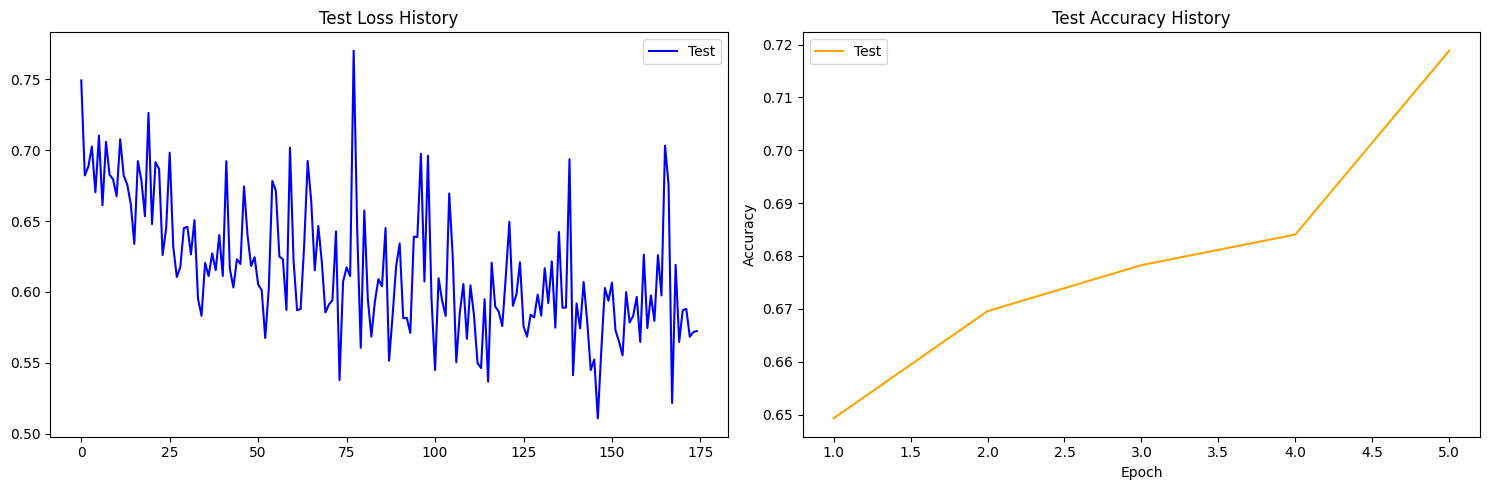

In [31]:
for i in range(len(loss_history)):
  loss_history[i]=loss_history[i].cpu().detach().numpy()
n_train = len(accuracy_history)

t_test = np.arange(1, n_epochs + 1)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

array=np.arange(len(loss_history))

# Plotting training accuracy history
axs[0].plot(array, loss_history, color='b', label="Test")
axs[1].plot(t_test, accuracy_history, label="Test", color='orange')
axs[0].legend()
axs[0].set_title('Test Loss History')
axs[1].set_title('Test Accuracy History')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


## 7. Debugging tools

### a) Confusion matrix

In [ ]:
# Convert PyTorch tensors to NumPy arrays
model.eval()
predictions = []
labels = []
model = model.to(device)

for data, target in test_loader:
  data, target = data.to(device), target.to(device)
  output = model(data)
  pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)
  pred = pred.cpu().numpy()
  target = target.cpu().numpy()

  predictions.append(pred)
  labels.append(target)

print("predictions: ", predictions)
print("labels: ", labels)


# Compute confusion matrix using scikit-learn
cm = confusion_matrix(labels, predictions)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### b) Visualize misclassified images

In [ ]:
# Set the model to evaluation mode
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

misclassified_images = []
true_labels = []
predicted_labels = []

# Iterate through the test set
for data, target in test_loader:
    # Forward pass
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = torch.argmax(output, dim=1).float().clone().detach().requires_grad_(False)

    # Identify misclassified images
    misclassified_mask = pred != target
    misclassified_images.extend(data[misclassified_mask])
    true_labels.extend(target[misclassified_mask])
    predicted_labels.extend(pred[misclassified_mask])

# Convert lists to PyTorch tensors
misclassified_images = torch.stack(misclassified_images)
true_labels = torch.stack(true_labels)
predicted_labels = torch.stack(predicted_labels)

# Assuming you have a function to reverse normalization if applied during data preprocessing
# Replace reverse_normalize with your actual function
# Example:
reverse_normalize = transforms.Compose([transforms.Normalize(mean=0, std=(1/62.7087)),
                                        transforms.Normalize(mean=-51.6644, std=1)])

# Display misclassified images
num_images_to_display = min(10, len(misclassified_images))
fig, axes = plt.subplots(1, num_images_to_display, figsize=(45,6))

for i in range(num_images_to_display):
    # Assuming images are in RGB format
    image = reverse_normalize(misclassified_images[i]).cpu().numpy()
    true_label = true_labels[i].item()
    predicted_label = predicted_labels[i].item()

    axes[i].imshow(image[15,:,:], cmap='sdoaia304')
    axes[i].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[i].axis('off')

plt.show()
